# **ÖDEVİ HAZIRLAYANLAR**
**G221210389  Buğra Kayacan 2-B**

**G211210059  Osman Tahir Özdemir 2-B**

**G211210301 Muhammed Fatih Seyhun 2-B**







**Kullanılan Algoritma -->** WGAN-GP with R-GCN for the generation of small molecular graphs

**Örnek Adresi -->** https://keras.io/examples/generative/wgan-graphs/

**Örnekteki dataset -->** Küçük Kuantum Mekanik Molekülleri (QM9)

**Kullanılan dataset -->** Çoklu Kuantum Mekanik Molekülleri (QM8)


# WGAN-GP with R-GCN for the generation of small molecular graphs algoritmasının tanımı
Bu öğreticinin temel amacı, WGAN-GP ve R-GCN gibi teknolojileri bir araya getirerek yeni moleküler grafikler oluşturmaktır. WGAN-GP modelini moleküler grafik verileriyle eğiterek, üreteci yeni moleküller üretmeyi öğrenir. Bu yeni moleküller, eğitim veri kümesindeki moleküllerle benzer özelliklere sahip olur. R-GCN bileşeni ise moleküler grafiklerin içerisindeki atomlar ve bağlar arasındaki karmaşık ilişkileri anlamak için kullanılır.

Sonuç olarak, WGAN-GP ve R-GCN'nin birleşimiyle güçlü bir moleküler grafik üretme sistemi elde edilir. Bu sistem, ilaç keşfi ve geliştirme süreçlerine önemli katkılar sağlayabilir. Yeni moleküllerin keşfedilmesinde ve farmasötik uygulamalar için uygun özelliklere sahip moleküllerin bulunmasında büyük bir potansiyel taşır. Bu generatif model, moleküler uzayın farklı bölgelerini keşfetmemize olanak tanır ve değerli moleküllerin keşfedilmesine yardımcı olabilir.

# Örnekte kullanılan QM9 datasetinin tanıtımı
Bu dataseti, CHONF elementlerinden oluşan 134.000 stabil küçük organik molekülün geometrik, enerjik, elektronik ve termodinamik özelliklerini içeren bir veri seti sunar. Bu moleküller, GDB-17 kimyasal evreninin bir alt kümesidir ve en fazla dokuz ağır atom içerir. Kuantum kimyasının B3LYP/6-31G(2df,p) seviyesinde hesaplanan özellikler, moleküler tasarım ve yapı-özellik ilişkileri çalışmalarında kullanılabilir. Ayrıca, baskın bir stoikiyometri için 6.095 yapısal izomer de rapor edilmiştir. Bu veri seti, yeni ilaçlar ve malzemelerin keşfi için benchmark oluşturabilir ve yeni yöntemlerin geliştirilmesine katkıda bulunabilir.

# Bizim kullandığımız QM8 datasetinin tanımı
QM8 veri seti, son zamanlarda küçük moleküllerin elektronik spektrumlarını ve uyarılmış durum enerjilerini modelleme üzerine yapılan bir çalışmadan gelir. Zaman bağımlı yoğunluk fonksiyonel teoriler (TDDFT) ve ikinci dereceden yaklaşımsal bağlı kümeleme (CC2) dahil olmak üzere çeşitli yöntemler, en fazla sekiz ağır atom içeren bir molekül koleksiyonuna (aynı zamanda GDB-17 veritabanının bir alt kümesi) uygulanmıştır. Toplamda, üç farklı yöntemde hesaplanan dört uyarılmış durum özelliği 22 bin örnekte mevcuttur.

Bu veri seti, Moleculenet Benchmark kapsamında yer alır ve moleküler spektroskopinin kuantum mekaniği hesaplamalarını modellemek için kullanılır.

# Örneği çalıştıralım

## Gerekli paketlerin indirilmesi

**RDKit, C++ ve Python'da yazılmış bir kimya bilgi bilimi ve makine öğrenimi yazılım koleksiyonudur. Bu öğreticide, RDKit, SMILES'ı molekül nesnelerine kolay ve verimli bir şekilde dönüştürmek için kullanılır. SMILES, bir molekülün yapısını ASCII dizesi biçiminde ifade eder. RDKit, verilen bir SMILES'ı doğru bir şekilde molekül nesnesine dönüştürmek için algoritmalar kullanır. Bu nesne daha sonra birçok moleküler özelliği/özelliklerini hesaplamak için kullanılabilir.**

In [92]:
pip -q install rdkit-pypi


**Molekül nesnelerinin kolayca görselleştirilmesine izin vermek için Pillow yüklü olmalıdır.**

In [93]:
pip -q install Pillow


**Paketlerin import edilmesi**

In [94]:
from rdkit import Chem, RDLogger  # RDKit ve RDLogger modüllerini içe aktar
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage  # RDKit'ten çizim işlevlerini içe aktar
import numpy as np  # NumPy kütüphanesini içe aktar
import tensorflow as tf  # TensorFlow kütüphanesini içe aktar
from tensorflow import keras  # TensorFlow'dan Keras'ı içe aktar

RDLogger.DisableLog("rdApp.*")  # RDKit'in log mesajlarını devre dışı bırak



**Bu öğreticide kullanılan veri seti MoleculeNet'ten alınan bir kuantum mekaniği veri seti (QM9)dir. Veri setinde birçok özellik ve etiket sütunu bulunmasına rağmen, sadece SMILES sütununa odaklanacağız. QM9 veri seti, grafikler oluşturmak için iyi bir başlangıç veri setidir çünkü bir molekülde bulunan maksimum ağır (hidrojen olmayan) atom sayısı sadece dokuzdur.**

SMILES: Cn1cncc1O
Num heavy atoms: 7


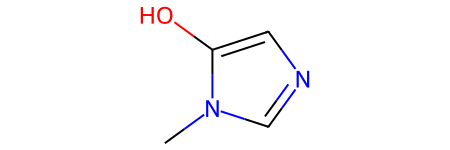

In [95]:
csv_path = tf.keras.utils.get_file(
    "qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Bir veri kümesi molekülüne bakalım
smiles = data[1000]
print("SMILES:", smiles)  # SMILES dizisini yazdır
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())  # Ağır atom sayısını yazdır
molecule


**Moleküler grafiklerin temsil edilmesi: Moleküller doğal olarak yönsüz grafikler olarak ifade edilebilir. Bu uygulamada, her graf (molekül), varlık/yokluklarını, bir boyutu daha uzatan bir sıcak kodlu bağ türleri ile atom çiftlerinin bulunmasıyla kodlayan bir komşuluk tensörü A ve her bir atom için atom tipini sıcak kodlayan bir özellik tensörü H olarak temsil edilecektir. RDKit tarafından hidrojen atomları çıkarılabileceğinden, modelleme işlemlerini kolaylaştırmak için A ve H'den hidrojen atomları hariç tutulmuştur.**

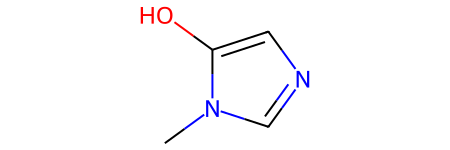

In [96]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 9  # Maksimum atom sayısı
ATOM_DIM = 4 + 1  # Atom türü sayısı
BOND_DIM = 4 + 1  # Bağ türü sayısı
LATENT_DIM = 64  # Latent uzay boyutu


def smiles_to_graph(smiles):
    # SMILES'ı molekül nesnesine dönüştür
    molecule = Chem.MolFromSmiles(smiles)

    # Komşuluk ve özellik tensörlerini başlat
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # Moleküldeki her atom için
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # Bir-hops komşuları için döngü
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Bağ yoksa, son kanala 1 ekle (bağsız olduğunu belirtir)
    # Dikkat: kanallar önce
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Atom yoksa, son sütuna 1 ekle (atom olmadığını belirtir)
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Grafikten molekülü çöz
    adjacency, features = graph

    # RWMol, düzenlenmesi amaçlanan bir molekül nesnesidir
    molecule = Chem.RWMol()

    # "Atom yok" & bağsız atomları kaldır
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Moleküle atom ekle
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Moleküldeki atomlar arasında bağ ekle; üst üçgenlere dayanarak
    # [simetrik] komşuluk tensörü
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Molekülü düzenle; daha fazla bilgi için
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Katı olalım. Düzenleme başarısız olursa, None döndür
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


# Yardımcı işlevleri test et
graph_to_molecule(smiles_to_graph(smiles))


# Eğitim setini oluştur
**Eğitim süresini kısaltmak için, sadece QM9 veri setinin onda birini kullanacağız.**

In [97]:
adjacency_tensor, feature_tensor = [], []

# Veri setinin onda birini kullanarak döngü
for smiles in data[::10]:
    # SMILES'i grafiklere dönüştür
    adjacency, features = smiles_to_graph(smiles)
    # Komşuluk tensörü ve özellik tensörünü ekle
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

# Listeleri numpy dizilerine dönüştür
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

# Tensör şekillerini yazdır
print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)


adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)



Modelin temelinde, bir üretici ağı ve bir ayırt edici ağı uygulanacaktır. Bu WGAN-GP aracılığıyla gerçekleştirilecek ve sonuç olarak küçük yeni moleküller (küçük grafikler) üretebilen bir üretici ağı elde edeceğiz.

Üretici ağı, her bir örneğin bir vektör z'sini (z'nin her bir örneği için) 3-B çevrilmişlik tensörü (A) ve 2-B özellik tensörüne (H) eşlemek için yetenekli olmalıdır. Bu amaçla, z önce tamamen bağlı bir ağa geçirilecek, çıktı daha sonra iki ayrı tamamen bağlı ağa geçirilecektir. Bu iki tam bağlı ağın her biri, ardından her bir örneğin için bir tanh-aktivasyonlu vektör çıktısı verecektir, ardından çok boyutlu bir komşuluk/özellik tensörü ile eşleşmesi için yeniden şekillendirme ve softmax ile devam edecektir.

Ayırt edici ağı, üreticiden veya eğitim setinden bir grafik (A, H) olarak girdi aldığında, grafik konvolüsyonel katmanları uygulamamız gerekecektir, bu da bize grafikler üzerinde işlem yapmamıza izin verecektir. Bu, ayırt edici ağına girişin önce grafik konvolüsyonel katmanlardan geçirilmesi, ardından bir ortalama havuzlama katmanına, ve son olarak birkaç tam bağlı katmana geçmesi gerektiği anlamına gelir. Son çıktı, her bir örneğin için "sahte" veya "gerçek" molekülün "gerçekliğini" gösteren bir skaler olmalıdır.

In [98]:
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape,
):
    # Giriş katmanı oluştur
    z = keras.layers.Input(shape=(latent_dim,))

    # Bir veya daha fazla yoğun bağlı katmandan geçir
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Önceki katmanın çıktılarını [sürekli] bitişiklik tensörlerine (x_adjacency) eşleştir
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Son iki boyutta tensörleri simetrize et
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Önceki katmanın çıktılarını [sürekli] özellik tensörlerine (x_features) eşleştir
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    # Modeli oluştur ve adını belirle
    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


# Örnek bir graf üreteci oluştur ve özetini al
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 dense_74 (Dense)            (None, 128)                  8320      ['input_27[0][0]']            
                                                                                                  
 dropout_46 (Dropout)        (None, 128)                  0         ['dense_74[0][0]']            
                                                                                                  
 dense_75 (Dense)            (None, 256)                  33024     ['dropout_46[0][0]']          
                                                                                          

Graf konvolüsyonel katmanlar, ilişkisel grafik yapılarında non-linear olarak dönüştürülmüş komşuluk birikimlerini uygular. Bu katmanlar aşağıdaki gibi tanımlanabilir:

H^{l+1} = σ(D^{-1} @ A @ H^{l} @ W^{l})

Burada σ non-linear dönüşümü (genellikle ReLU aktivasyonu olarak) ifade eder, A komşuluk tensörünü, H^{l} l:inci katmandaki özellik tensörünü, D^{-1} A'nın ters çap derecesi tensörünü, ve W^{l} l:inci katmandaki eğitilebilir ağırlık tensörünü gösterir. Özellikle, her bağ türü (ilişki) için, derece tensörü, köşelere bağlı bağ sayısını diyagonalde ifade eder. Bu öğreticide D^{-1} ihmal edilmiştir, iki nedenle: (1) bu normalizasyonun, üretilen sürekli komşuluk tensörleri üzerinde nasıl uygulanacağı açık değildir ve (2) normalizasyon olmadan WGAN'ın performansı oldukça iyi görünmektedir. Ayrıca, orijinal makalenin aksine, hiçbir kendinden döngü tanımlanmamıştır, çünkü üreteciyi "kendine bağlanmayı" tahmin etmesi için eğitmek istemiyoruz.

In [99]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        # Katmanın parametrelerini tanımla
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        # Giriş şeklinden bağ boyutunu ve atom boyutunu al
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        # Ağırlıkları oluştur
        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            # Bias terimini oluştur (opsiyonel)
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Komşulardan bilgi topla
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Doğrusal dönüşüm uygula
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Bağ türlerini azalt
        x_reduced = tf.reduce_sum(x, axis=1)
        # Doğrusal olmayan dönüşüm uygula
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):
    # Giriş katmanlarını tanımla
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Graf konvolüsyon katmanlarından geçir
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Molekülün 2-B temsilini 1-B'ye indirge
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Yoğun bağlı katmanlardan geçir
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Her bir molekül için, girdi molekülün "gerçekliğini" ifade eden tek bir skalar değeri çıkar
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


# Örnek bir graf ayırıcısı oluştur ve özetini al
discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 5, 9, 9)]            0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 9, 5)]               0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 9, 128)               3200      ['input_28[0][0]',            
 r_32 (RelationalGraphConvL                                          'input_29[0][0]']            
 ayer)                                                                                            
                                                                                            

# WGAN-GP

In [100]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        # Modeli başlat
        super().__init__(**kwargs)

        # Generator ve discriminator modellerini kaydet
        self.generator = generator
        self.discriminator = discriminator

        # Adımlar ve ağırlıklar için gerekli parametreleri tanımla
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight

        # Girdi boyutunu belirle
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        # Derleme işlemi için optimizasyon ve metrikleri ayarla
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):
        # Girdi verisini kontrol et
        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        # Batch boyutunu al
        self.batch_size = tf.shape(inputs[0])[0]

        # Discriminator'ı bir veya daha fazla adım için eğit
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Generator'ı bir veya daha fazla adım için eğit
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        # Gerçek ve üretilmiş grafiklerin logitlerini hesapla
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        # Discriminator kaybını hesapla
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        # Gradyan sapması (gradient penalty) kaybını hesapla ve ağırlıkla çarp
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        # Üretilmiş grafiklerin logitlerini hesapla
        logits_generated = self.discriminator(graph_generated, training=True)
        # Generator kaybını hesapla
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Grafikleri aç
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Aradaki grafikleri oluştur (adjacency_interp ve features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Aradaki grafiklerin logitlerini hesapla
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Aradaki grafiklerin gradyanlarını hesapla
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Gradyan sapması (gradient penalty) hesapla
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )


# Modeli eğitme


In [101]:
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)

wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)

Epoch 1/10
837/837 [==============================] - 99s 104ms/step - loss_gen: 2.0107 - loss_dis: -4.2733
Epoch 2/10
837/837 [==============================] - 84s 101ms/step - loss_gen: 0.9426 - loss_dis: -1.2596
Epoch 3/10
837/837 [==============================] - 86s 103ms/step - loss_gen: 0.9399 - loss_dis: -1.8420
Epoch 4/10
837/837 [==============================] - 85s 101ms/step - loss_gen: 1.1516 - loss_dis: -2.3172
Epoch 5/10
837/837 [==============================] - 88s 105ms/step - loss_gen: 0.7622 - loss_dis: -2.0779
Epoch 6/10
837/837 [==============================] - 90s 107ms/step - loss_gen: 1.0277 - loss_dis: -2.0800
Epoch 7/10
837/837 [==============================] - 89s 107ms/step - loss_gen: 0.8980 - loss_dis: -1.8065
Epoch 8/10
837/837 [==============================] - 88s 105ms/step - loss_gen: 0.6268 - loss_dis: -1.6731
Epoch 9/10
837/837 [==============================] - 89s 106ms/step - loss_gen: 0.5356 - loss_dis: -1.7180
Epoch 10/10
837/837 [=======

# Üreteciyle yeni moleküller örnekleyelim

2/2 [==============================] - 0s 7ms/step


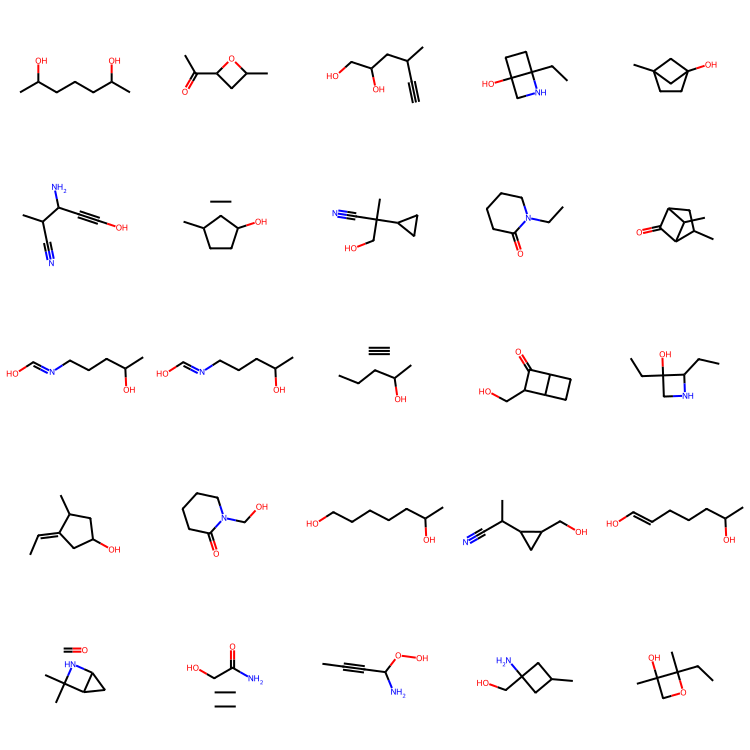

In [102]:
def sample(generator, batch_size):
    # Belirtilen sayıda rastgele latent vektör oluştur
    z = tf.random.normal((batch_size, LATENT_DIM))
    # Generatorü kullanarak graf üret
    graph = generator.predict(z)

    # One-hot kodlu kenar tensorünü al
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Olası kendinden döngüleri kenar tensöründen kaldır
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))

    # One-hot kodlu özellik tensorünü al
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

    # Grafı moleküle dönüştür
    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]

# WGAN generator ile örnekler oluştur
molecules = sample(wgan.generator, batch_size=48)

# Oluşturulan molekülleri görselleştir
MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)


Örnek dataset tamamlandı.



**----------------------------------------------------**

# Şimdi bulduğumuz farklı datasetini koda uyarlayarak kendimiz eğiteceğiz

**Datasetini indirip moleküle bir göz atalım**

SMILES: [H]C(=O)c1nc([H])c([H])n1[H]
Num heavy atoms: 7


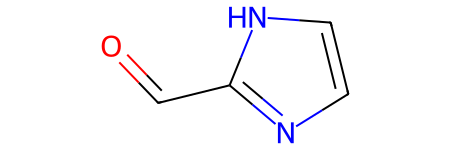

In [103]:
# Veri kümesini indir
csv_path = tf.keras.utils.get_file(
    "qm8.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm8.csv"
)

# Dosyadan verileri oku ve SMILES dizinine ekle
data2 = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data2.append(line.split(",")[0])

# Veri kümesindeki bir moleküle bakalım
smiles = data2[1000]
print("SMILES:", smiles)

# SMILES dizgisinden bir RDKit molekülü oluştur
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())

# Oluşturulan molekülü görselleştir
molecule


**Atomları ve bağları güncelliyoruz**

In [104]:
# Atom türlerini ve bağ tiplerini sayısal olarak temsil etmek için kullanılacak eşleme sözlükleri
atom_mapping = {
    "C": 0,  # Karbon atomunu 0 olarak temsil et
    0: "C",  # 0 sayısını karbon atomuna dönüştür
    "N": 1,  # Azot atomunu 1 olarak temsil et
    1: "N",  # 1 sayısını azot atomuna dönüştür
    "O": 2,  # Oksijen atomunu 2 olarak temsil et
    2: "O",  # 2 sayısını oksijen atomuna dönüştür
    "F": 3,  # Flor atomunu 3 olarak temsil et
    3: "F",  # 3 sayısını flor atomuna dönüştür
    "H": 4,  # Hidrojen atomunu 4 olarak temsil et
    4: "H",  # 4 sayısını hidrojen atomuna dönüştür
}

bond_mapping = {
    "SINGLE": 0,    # Tek bağı 0 olarak temsil et
    0: Chem.BondType.SINGLE,   # 0 sayısını tek bağ tipine dönüştür
    "DOUBLE": 1,    # Çift bağı 1 olarak temsil et
    1: Chem.BondType.DOUBLE,   # 1 sayısını çift bağ tipine dönüştür
    "TRIPLE": 2,    # Üçlü bağı 2 olarak temsil et
    2: Chem.BondType.TRIPLE,   # 2 sayısını üçlü bağ tipine dönüştür
    "AROMATIC": 3,  # Aromatik bağı 3 olarak temsil et
    3: Chem.BondType.AROMATIC,  # 3 sayısını aromatik bağ tipine dönüştür
}

NUM_ATOMS = 9  # Maksimum atom sayısı
ATOM_DIM = 4 + 1  # Atom tiplerinin sayısı + 1 (diğer)
BOND_DIM = 4 + 1  # Bağ tiplerinin sayısı + 1 (diğer)
LATENT_DIM = 64  # Latent uzayın boyutu

# SMILES dizgisini bir molekül grafiğine dönüştüren ve ardından molekül yapısını döndüren fonksiyonu çağır
graph_to_molecule(smiles_to_graph(smiles))


**Örnekte zamandan tasarruf için veri setinin 10 da birini kullanırken biz tüm datasetini kullanarak eğitilcek verileri ayarlıyoruz**

In [105]:
adjacency_tensor, feature_tensor = [], []
for smiles in data2[::1]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (21786, 5, 9, 9)
feature_tensor.shape = (21786, 9, 5)


In [106]:
# GraphGenerator modeli oluştur
generator = GraphGenerator(
    dense_units=[128, 256, 512],                # Yoğun katmanlardaki birim sayıları
    dropout_rate=0.2,                           # Bırakma oranı
    latent_dim=LATENT_DIM,                      # Gizli uzay boyutu
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),  # Kenar tensörünün şekli
    feature_shape=(NUM_ATOMS, ATOM_DIM),        # Özellik tensörünün şekli
)

# Model özetini görüntüle
generator.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 dense_82 (Dense)            (None, 128)                  8320      ['input_30[0][0]']            
                                                                                                  
 dropout_51 (Dropout)        (None, 128)                  0         ['dense_82[0][0]']            
                                                                                                  
 dense_83 (Dense)            (None, 256)                  33024     ['dropout_51[0][0]']          
                                                                                          

In [107]:
# GraphDiscriminator modelini oluştur
discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],            # Graf farklılaştırıcı birimleri
    dense_units=[512, 512],                      # Yoğun katmanlardaki birim sayıları
    dropout_rate=0.2,                            # Bırakma oranı
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),  # Kenar tensörünün şekli
    feature_shape=(NUM_ATOMS, ATOM_DIM),         # Özellik tensörünün şekli
)

# Model özetini görüntüle
discriminator.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 5, 9, 9)]            0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 9, 5)]               0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 9, 128)               3200      ['input_31[0][0]',            
 r_36 (RelationalGraphConvL                                          'input_32[0][0]']            
 ayer)                                                                                            
                                                                                            

**Modelimizi farklı datasetiyle eğitiyoruz**

In [108]:
# GraphWGAN modelini oluştur
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

# Modeli derle
wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),         # Üreteci optimizer
    optimizer_discriminator=keras.optimizers.Adam(5e-4),     # Farklılaştırıcı optimizer
)

# Modeli veriyle eğit
wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)


Epoch 1/10
1362/1362 [==============================] - 152s 106ms/step - loss_gen: 1.3178 - loss_dis: -3.0260
Epoch 2/10
1362/1362 [==============================] - 136s 100ms/step - loss_gen: 0.4142 - loss_dis: -1.1586
Epoch 3/10
1362/1362 [==============================] - 139s 102ms/step - loss_gen: 0.8871 - loss_dis: -2.1482
Epoch 4/10
1362/1362 [==============================] - 137s 101ms/step - loss_gen: 0.9742 - loss_dis: -2.3112
Epoch 5/10
1362/1362 [==============================] - 139s 102ms/step - loss_gen: 0.5185 - loss_dis: -1.8371
Epoch 6/10
1362/1362 [==============================] - 137s 100ms/step - loss_gen: 0.8484 - loss_dis: -1.6823
Epoch 7/10
1362/1362 [==============================] - 146s 107ms/step - loss_gen: 0.7809 - loss_dis: -1.8927
Epoch 8/10
1362/1362 [==============================] - 138s 102ms/step - loss_gen: 0.8552 - loss_dis: -1.5889
Epoch 9/10
1362/1362 [==============================] - 138s 101ms/step - loss_gen: 0.5391 - loss_dis: -1.5732
E

**Eğittiğimiz model ile birkaç örnek oluşturalım**

2/2 [==============================] - 0s 7ms/step


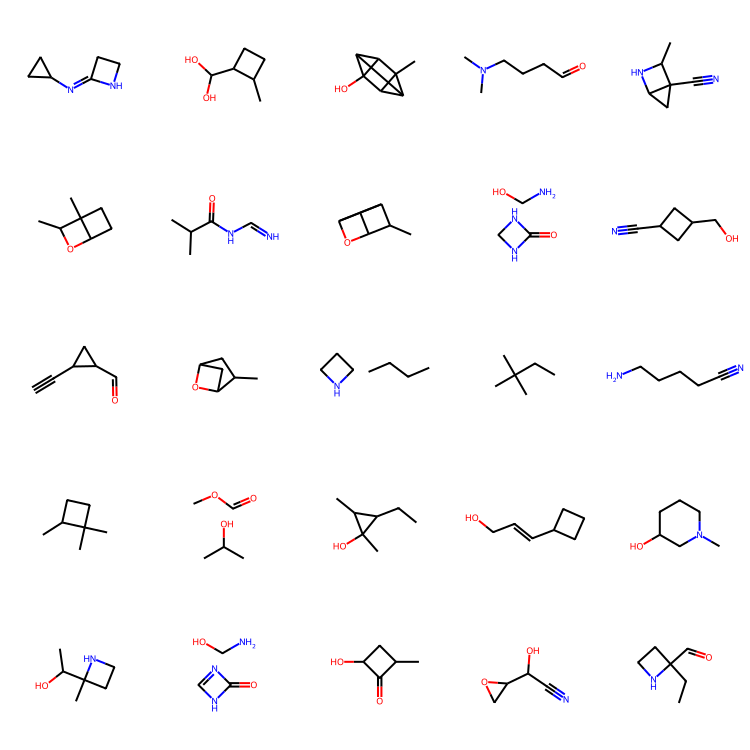

In [109]:
# WGAN generator kullanarak molekül örnekleri oluştur
molecules = sample(wgan.generator, batch_size=48)

# Oluşturulan molekülleri görselleştir
MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)


# REFERANSLAR
## https://keras.io/examples/generative/wgan-graphs/
## https://www.kaggle.com/datasets/zaharch/quantum-machine-9-aka-qm9
## https://www.kaggle.com/datasets/shivanshuman/quantum-machine-8-aka-qm8
## https://moleculenet.org/datasets-1